# Channel Estimation and Linear Equalization

Until now, we have avoided dispersive channels, i.e., channels that perform undesired linear filtering of the transmitted signal.
We will show that channel dispersion cannot be ignored by the receiver as it leads to unacceptable error rates.

Since the impulse response of the channel is usually unknown, we must either explicitly estimate the channel impulse response or adapt the equalizer such that the channel dispersion is ameliorated. 

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/080_equalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/080_equalization.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [69]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np
from scipy import signal
from scipy.linalg import toeplitz

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# the next cells, repeat code from earlier notebooks. It would be better to import these but
# then the notebook is no longer self-contained

In [2]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [3]:
def srrc_pulse(a, fsT, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - lenght of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [4]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

## What happens when the channel is dispersive

To illustrate the detrimenatal effects of channel dispersion, we conduct a simple experiment. We pass a QPSK signal with $N=200$ symbols through a simple dispersive channel characterized by the (upsampled) impulse response
$$
    c_M[n] = [0.1, 0, -0.3j, 0, 0, 1, 0, 0, 0, 0.3j, 0, 0, 0, 0, 0.2-0.7j, 0, 0, 0, 0, 0, 0.1j].
$$
The channel has a delay spread that spans $L=5$ symbol periods.

The channel does not add noise, so that we can focus on the effects of dispersion alone.

In [24]:
## genee=rate a QPSK signal
fsT = 4
N = 200
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK alphabet
pp = srrc_pulse(0.5, fsT, 5)

syms = random_symbols(A, N)
sig = pulse_shape(syms, pp, fsT)


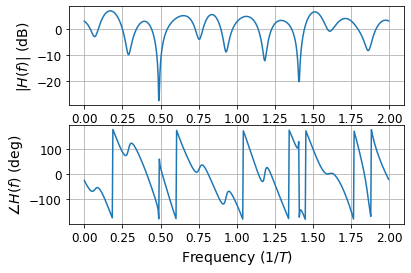

In [64]:
## dispersive channel
hh = np.array([0.1, 0, -0.3j, 0, 0, 1, 0, 0, 0, 0.3j, 0, 0, 0, 0, 0.2-0.7j, 0, 0, 0, 0, 0, 0.1j])

# received signal
rr = np.convolve(sig, hh)

# plot the frequency reponse of the channel
w, H = signal.freqz(hh, whole=True)
ax1=plt.subplot(2,1,1)
ax1.plot(w/np.pi, 20*np.log10(np.abs(H)))
ax1.set_ylabel('$|H(f)|$ (dB)')
ax1.grid()
ax2=plt.subplot(2,1,2)
ax2.plot(w/np.pi, np.angle(H)/np.pi*180)
ax2.set_ylabel(r'$\angle H(f)$ (deg)')
ax2.set_xlabel('Frequency ($1/T$)')
ax2.grid()
plt.show()

The first illustration of the effect of the channel disepersion are the eye diagrams below. Recall that an eye diagram consists of plotting segments of the received signal spanning two symbol periods on top of each other.

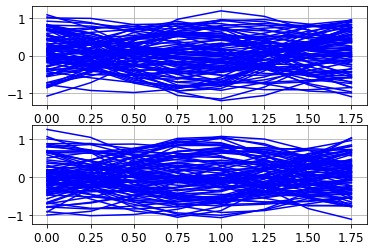

In [65]:
## Eye diagram, plot repeatedly two consecutive symbols
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

start = len(hh) + len(pp)               # trim transient at beginning
end = start + 2*fsT

while end < len(rr) -len(hh) - len(pp): # trim transient at end
    seg = rr[start : end]
    ax1.plot(np.arange(2*fsT)/fsT, seg.real, 'b')
    ax2.plot(np.arange(2*fsT)/fsT, seg.imag, 'b')
    start += 2*fsT
    end += 2*fsT

ax1.grid()
ax2.grid()
plt.show()

The "eyes" are completely closed. There is no sampling instance that allows the symbols to be separated.

For comparison, the plot below shows a perfect eye diagram for QPSK signals. The ideal sampling periods at $t=0.5T$ (or $t=1.5T$) are clearly visible. Note that at those time instances the signal values are all equal to $\pm \frac{\sqrt{2}}{2}$.

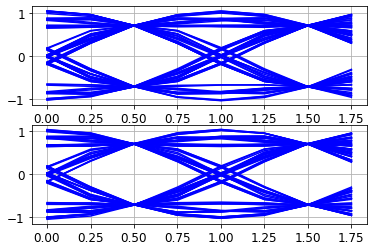

In [66]:
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

rs = np.convolve(sig, pp)
start = len(hh) + len(pp)
end = start + 2*fsT

while end < len(rr) -len(hh) - len(pp):
    seg = rs[start : end]
    ax1.plot(np.arange(2*fsT)/fsT, seg.real, 'b')
    ax2.plot(np.arange(2*fsT)/fsT, seg.imag, 'b')
    start += 2*fsT
    end += 2*fsT

ax1.grid()
ax2.grid()
plt.show()

For the second illustration, we plot a scatter plot of the received signals. Since the oversampling factor is `fsT` is equal to 4, we plot four such scatter plots, one for each sampling phase, in different colors.

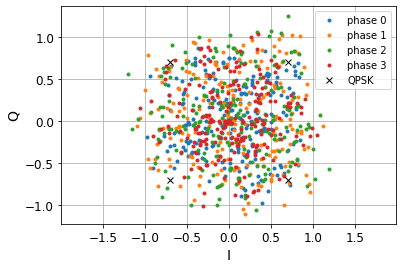

In [67]:
for n in range(fsT):
    plt.plot(rr[n::fsT].real, rr[n::fsT].imag, '.', label="phase {:d}".format(n))
plt.plot(A.real, A.imag, 'kx', label='QPSK')

plt.xlabel('I')
plt.ylabel('Q')
plt.grid()
plt.axis('equal')
plt.legend()
plt.show()

None of the sampling phases, resembles a QPSK constellation.

## Convolution via matrix multiplication

In preparation for devising methods to estimate the channel and to design an equalizer, we need to reformulate the problem. 

The convolution performed by the channel impulse response is difficult to work with. A formulation that expresses the convolution operation as matrix multiplication leads to a much more tractable formulation.

To make matters concrete, we will illustrate the conversion from convolution to matrix multiplication using:

* a short input signal $s[n]$ consisting of $N=8$ symbols with values 1 through 8,
* a short channel with impulse response $c[k] = [1, -2, 3]$,
* the signal is over sampled $M=2$ times. 

The resulting signal $r[k]$ is given by
$$
    r[k] = \sum_{n=0}^7 s[n] \cdot c[k - nM].
$$

This operation is equivalent to first upsampling the input signal, by inserting $M-1$ zeros between samples, and then convolving the upsampled signal with the $c[k]$. 

Throughout, $n$ counts symbol periods and $k$ counts sample periods. 

In [46]:
## generate signal r[k]
ss = np.arange(1, 9)
cc = np.array([1,-2,3])
M = 2

# the output signal has M*(len(ss)-1) + len(cc) non-zero samples
rr = np.zeros(M*(len(ss)-1) + len(cc))
for k in range(len(rr)):
    for n in range(len(ss)):
        if k - M*n >= 0 and k - M*n < len(cc):
            rr[k] += ss[n]*cc[k - M*n]

rr

array([  1.,  -2.,   5.,  -4.,   9.,  -6.,  13.,  -8.,  17., -10.,  21.,
       -12.,  25., -14.,  29., -16.,  24.])

In [52]:
## alternative computation via upsampling and convolution 
up_ss = np.zeros(M * (len(ss) - 1) + 1, dtype=ss.dtype)
up_ss[::M] = ss

np.convolve(up_ss, cc)

array([  1,  -2,   5,  -4,   9,  -6,  13,  -8,  17, -10,  21, -12,  25,
       -14,  29, -16,  24])

Note that the nested loops in the code above are reminiscent of a matrix multiplication. Recall that the multiplication of a $K \times N$ matrix $\mathbf{C}$  with a length $N$ vector $\vec{s}$, yields a length $K$ vector $\vec{r}$. 

The elements of the resulting vector $\vec{r}$ are given by:
$$
    r[k] = \sum_{n=0}^{N-1} A_{k,n} s_n.
$$
This computation is repeated for each of the $K$ elements of $\vec{r}$, which leads to the nested loop for computing the product of $\mathbf{C}$ and $\vec{s}$.

From this analogy, we can define a channel matrix $\mathbf{C}$ such that when it is multiplied by the vector of input symbols yields the output signal.

The computation of matrix $\mathbf{C}$ parallels the convolution operation above.

In [47]:
# the channel matrix CC has dimensions M*(len(ss)-1) + len(cc) by len(ss)
CC = np.zeros((M*(len(ss)-1) + len(cc), len(ss)))
for k in range(len(rr)):
    for n in range(len(ss)):
        if k - M*n >= 0 and k - M*n < len(cc):
            CC[k, n] = cc[k - M*n]

CC

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  3.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  3.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  3.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]])

The matrix $\mathbf{C}$ consists of $N=8$ columns. The $n$-th column begins with $nM$ zeros and is followed by the impulse response $c[k]$. Any remaining positions in the $n$-th column are filled with zeros.

To verify that the product of matrix $\mathbf{C}$ and vector $\vec{s}$ yields the received signal $r[k]$, i.e. is equaivalent to the above convolution, we simply comput that product and compare to the prior result.

In [51]:
# matrix multiplication operator in Python is @ (strange)
r_m = CC @ ss

assert np.allclose(rr, r_m)

r_m

array([  1.,  -2.,   5.,  -4.,   9.,  -6.,  13.,  -8.,  17., -10.,  21.,
       -12.,  25., -14.,  29., -16.,  24.])

We can indeed compute the convolution of the up-sampled input signal and the channel impulse response by a matrix multiplication.

### Another way to use matrix multiplication

Convolution is a symmetric operation. Hence, it should be possible to reverse the roles of inputs signal $s[n]$ and channel impulse response $c[n]$.

We should be able to formulate the upsampled convolution as a product of a matrix formed from the input symbols and a vector that equals the impulse response.

This formulation will be used when we seek to estimate the channel impulse response.

Starting with the original up-sampled convolution, we obtain the alternative formulation by substituting $l=k-nM$. This leads to
$$
    r[k] = \sum_{n=0}^{N-1} s[n] \cdot c[k - nM] = \sum_{l: k-l=nM} c[l] \cdot s[(k-l)/M].
$$
Because of the upsampling of the input signal, the alternative formulation is slightly awkward; the summation includes only terms for which $l$ is such that $k-l$ is a non-negative integer multiple of $M$ (and $l < L$).

Nevertheless, we can compute an input signal matrix $\mathbf{S}$ based on this convolution operation:

In [59]:
# the channel matrix SS has dimensions M*(len(ss)-1) + len(cc) by len(cc)
SS = np.zeros((M*(len(ss)-1) + len(cc), len(cc)))
for k in range(len(rr)):
    for l in range(len(cc)):
        if k - l >= 0 and k - l < M*len(ss) and (k - l) % M == 0:
            SS[k, l] = ss[(k-l)//M]

SS

array([[1., 0., 0.],
       [0., 1., 0.],
       [2., 0., 1.],
       [0., 2., 0.],
       [3., 0., 2.],
       [0., 3., 0.],
       [4., 0., 3.],
       [0., 4., 0.],
       [5., 0., 4.],
       [0., 5., 0.],
       [6., 0., 5.],
       [0., 6., 0.],
       [7., 0., 6.],
       [0., 7., 0.],
       [8., 0., 7.],
       [0., 8., 0.],
       [0., 0., 8.]])

The matrix $\mathbf{S}$ has a simple structure:

* Each column contains the information symbols followed by $M-1$ zeros. Another way to say this: each column contains the upsampled signal.
* In the $n$-th column, the signal is preceded by $n$ zeros.

Thus, the matrix $\mathbf{S}$ is a Toeplitz matrix with the first column given by the up-sampled signal.

Let's again verify that the multiplication of matrix $\mathbf{S}$ and the channel vector $\vec{c}$ yields the received samples:

In [60]:
## multiply S
r_s = SS @ cc
assert np.allclose(rr, r_m)

r_m

array([  1.,  -2.,   5.,  -4.,   9.,  -6.,  13.,  -8.,  17., -10.,  21.,
       -12.,  25., -14.,  29., -16.,  24.])

## Estimating the channel impulse response

We have shown that the vector of received samples can be modeled via the multiplication of a matrix and a vector, plus additive Gaussian noise.

For the purpose of estimating the impulse response $c[k]$, the form with the signal matrix $\mathbf{S}$ is useful. We can write:
$$
    \vec{r} = \mathbf{S} \vec{c} + \vec{N}.
$$

When a training sequence $s_t[n]$ is available, we can construct the signal matrix $\mathbf{S_t}$ from that training signal. 

The goal is then to estimate the channel vector $\vec{c}$ from the vector of received samples $r[l]$ and the training matrix $\mathbf{S_t}$.

The maximum-likelihood estimate of the channel vector is
$$
\vec{\hat{c}} = \arg \min_{\vec{c}} \|\vec{r} - \mathbf{S} \vec{c}\|^2.
$$

The solution to this optimization problem is
$$
    \vec{c} = \mathbf{S}^+ \vec{r}
$$
where $\mathbf{S}^+$ denotes the (Moore-Penrose) pseudo-inverse of $\mathbf{S}$. Since the columns of $\mathbf{S}$ are independent, the pseudo-inverse equals $\mathbf{S}^+ = (\mathbf{S}^H \mathbf{S})^{-1}\mathbf{S}^H$ and, therefore,
$$
    \vec{c} = (\mathbf{S}^H \mathbf{S})^{-1}\mathbf{S}^H \vec{r}
$$

Note: computing the pseudo-inverse is numerically more stable than the explicit inverse. In NumPy, the pseudo-inverse is provided by `np.linalg.pinv`.

Let's verify that we can obtain the channel coefficents $c[k]$ from the samples $r[k]$ and the matrix $\mathbf{S}$.

In [63]:
## show that S+ times rr equals cc
c_hat = np.linalg.pinv(SS) @ rr

assert np.allclose(cc, c_hat)

c_hat

array([ 1., -2.,  3.])

For a more realistic example, we return to the channel used earlier and QPSK symbols. Additionally the received signal samples also contain noise.

We skip the pulse-shaping for this example, so that the impulse response `hh` reflects pulse shaping, channel dispersion, and receiver filtering.

In [90]:
## generate a QPSK signal
fsT = 4
N = 200
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK alphabet

syms = random_symbols(A, N)

## dispersive channel
cc = np.array([0.1, 0, -0.3j, 0, 0, 1, 0, 0, 0, 0.3j, 0, 0, 0, 0, 0.2-0.7j, 0, 0, 0, 0, 0, 0.1j])
sig = pulse_shape(syms, cc, fsT)

SNR_db = 10
SNR = 10**(SNR_db/10)

# received signal
rr = sig + 1/(np.sqrt(2*SNR))*(np.random.randn(len(sig)) + 1j*np.random.randn(len(sig)))


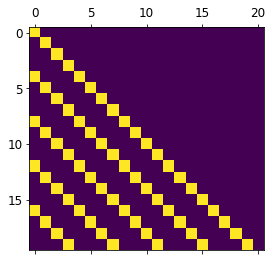

In [91]:
## construct the matrix S via upsampling and use of scipy.linalg.toeplitz
# the first columns of S is the upsampled symbols vector
ss = np.zeros_like(rr)
ss[0:N*fsT:fsT] = syms

# the first row is [syms[0], 0, ..., 0]
sr = np.zeros_like(hh)
sr[0] = syms[0]

SS = toeplitz(ss, sr)

# visualize the first few rows of SS - look for band-structure
plt.matshow(np.abs(SS[:20,:]))

With the $\mathbf{S}$ matrix in hand, we can proceeed to estimate the channel vector $\vec{c}$. 

We will vary the number of received symbols used to estimate $\vec{c}$ and track the accuracy of the estimate. Since the vector `cc` has 21 elements, we will use at least that many samples for channel estimation.

To measure the quality of the estimate, we measure the mean-squared error (MSE) between the received signal $\vec{r}$ and the reconstructed signal $\mathbf{S}\vec{\vec{\hat{c}}}$ over the entire received signal. 

In [96]:
## estimate using different numbers of received samples
K = np.arange(24, len(rr), 2*fsT, dtype=int)
len_K = len(K)
MSE = np.zeros(len_K)

for n in range(len_K):
    this_K = K[n]            # number of received samples to use
    this_rr = rr[:this_K]    # trim rr
    this_SS = SS[:this_K, :] # and SS

    c_hat = np.linalg.pinv(this_SS) @ this_rr

    MSE[n] = np.mean(np.abs(rr - SS@c_hat)**2)

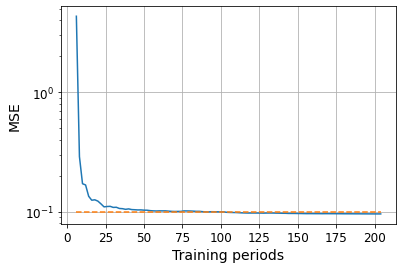

In [100]:
# plot MSE
plt.semilogy(K/fsT, MSE)
plt.semilogy(K/fsT, 1/SNR * np.ones_like(K), '--')

plt.xlabel('Training periods')
plt.ylabel('MSE')
plt.grid()

We can observe that bewteen 25 and 50 training periods is sufficient to estimate the channel. Additional training periods do not improve the quality of the estimate. 

Note, that this observation is specific to the length of the channel. As a rough rule of thumb, you need about 4 or 5 samples per element of the channel impulse response $c[k]$. This implies that the number training periods should be 4-5 times larger than the delay spread $\tau_c$ normalized by the symbol period $T$, $L = \lceil \frac{\tau_c}{T} \rceil$.

## Equalization

An equalizer is a filter with $K$ filter coefficients $w[k]$. The equalizer (usually) works on the $M$ times oversampled signal; this is called a fractionally spaced equalizer.

However, from the perspective of designing the equalizer it is easier to think of the equalizer as taking the inner product between sliding blocks of $K$ consecutive received samples and a vector of equalizer weights $\vec{v}$. The elements of $\vec{v}$ and the impulse response $w[k]$ are related via $w[K-k] = v_k^*$, where $v_k$ is the $k$-th element of $\vec{v}$.

To be specific, to equalize the $m$-th symbol, we construct a length-$K$ vector from the received samples $r[k]$
$$
    \vec{r}_K[m] = [r[k]] \quad \text{for $mM-K_1 < k \leq mM + (K-K_1)$.}
$$
When $K \geq LM$, then $K_1 = K-K_1 = K/2$ is a good choice. 

Note that in each symbol period the window of samples contained in $\vec{r}_K[m]$ advances by $M$ samples.




 

Recall that the received signal samples $r[k]$ can be expressed in terms of the channel matrix $\mathbf{C}$ and the vector of input symbols $\vec{s}$
$$
\vec{r} = \mathbf{C} \vec{s} + \vec{N}.
$$

Selecting consecutive $K$ elements of the received signal $r[k]$ indicates directly which rows of $\mathbf{S}$ are required.

For example for a window size of $K=6$, the vector $\vec{r}_K[2]$ would contain samples $r[4]$ through $r[9]$. The corresponding $K=7$ rows of the matrix
are computed below.

In [111]:
# receonstruct the matrix CC for channel [1, -2,3]
cc = np.array([1,-2,3])
M = 2
N = 8
# the channel matrix CC has dimensions M*(len(ss)-1) + len(cc) by len(ss)
CC = np.zeros((M*(N-1) + len(cc), N))
for k in range(M*(N-1) + len(cc)):
    for n in range(N):
        if k - M*n >= 0 and k - M*n < len(cc):
            CC[k, n] = cc[k - M*n]

# display the first 7 rows
CC[4:10]

array([[ 0.,  3.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  3.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -2.,  0.,  0.,  0.]])

Note that the first and the trailing three columns of the submatrix containing these $K=6$ rows of $\mathbf{C}$ are all zero. 

Clearly, we don't need those columns. Moreover, the symbols associated with these columns $s[1]$ and $s[4]$ through $s[7]$ do not contribute to the samples $r[4]$ through $r[9]$. Only symbols $s[1]$ through $s[4]$ contribute to those received samples.

Therefore, we can express the vector $\vec{r}_K[2]$ in terms of the $6 \times 4$ submatrix $\mathbf{C}_{[4:10,1:5]}$ and the vector $\vec{s}_4[2]$ consisting  of elements $s[1]$ through $s[4]$:
$$
    \vec{r}_K[2] = \mathbf{C}_{4:10,1:4} \cdot \vec{s}_4[2].
$$

Continuing our examples,  the next vector $\vec{r}_K[3]$ of received samples contains samples $r[6]$ through $r[11]$ and the corresponding rows of the channel matrix are:

In [110]:
CC[6:11]

array([[ 0.,  0.,  3.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  1.,  0.,  0.]])

Notice that this time the first two and the last two columns are all zero. That tells us that the contrinuting input symbols are $s[2]$ through $s[5]$ and vector $\vec{s}_4[3]$ contains those symbols.

Moreover, the remaining columns in the center are exactly the same as before, i.e., $\mathbf{C}_{[4:10,1:4]}$ = $\mathbf{C}_{[6:12,2:6]}$.

In conclusion, we recognize that the vectors $\vec{r}_k[m]$ are related to a vector of input symbols $\vec{s}_4[m]$ via a *constant* submatrix $\mathbf{C}_{K} = \mathbf{C}_{[2:8,0:4]}$.

In [117]:
CC_K = CC[2:8,0:4]
CC_K

array([[ 3.,  1.,  0.,  0.],
       [ 0., -2.,  0.,  0.],
       [ 0.,  3.,  1.,  0.],
       [ 0.,  0., -2.,  0.],
       [ 0.,  0.,  3.,  1.],
       [ 0.,  0.,  0., -2.]])

The model for the $m$-th received signal block is therefore
$$
    \vec{r}_K[m] = \mathbf{C}_{K} \cdot \vec{s}_N[m] + \vec{N}
$$

Note, minor difficulties arise at the start and end of the received block, where it may be necessary to assume that preceding or subsequent observations, e.g., $r[-1]$, are eqaul to zero.

### Zero-Forcing Equalizer

An equalizer computes the inner product of the equalizer vector $\vec{v}$ and each block of received samples $\vec{r}_K[m]$. The result is a scalar that should approximate the $m$-th symbol $s[m]$.

The zero-forcing equalizer accomplishes equalization by requring that in each block,
$$
    \vec{v}^H \cdot (\mathbf{C}_k \cdot \vec{s}_N[m]) = s_m,
$$
Note that $s_m is an element of $\vec{s}_N[m]$; let's say that $s_m$ is the $d$-th element of $\vec{s}_N[m]$.

Then, the equalizer vector $\vec{v}$ must satisfy
$$
    \vec{v}\mathbf{C}_K = \vec{e}_d^T = [0, \ldots, 0, 1, 0,\ldots 0] \quad \text{where the $1$ is in the $d$-th position.}
$$

Note that the linear syste of equations is under-determined; $K \approx 2N$, i.e., there are more elements of $\vec{v}$ than constraints. The solution is made unique by requiring that $\vec{\hat{v}}$ has the smalles norm of all solutions.

Hence, $\vec{\hat{v}}$ is the solution to the optimization problem:
$$
    \vec{\hat{v}} = \arg \min_{\vec{v}} \|\vec{v}\|^2 \quad \text{subject to: $\vec{v}\mathbf{C}_K = \vec{e}_d^T$} 
$$

The solution to this problem is
$$
    \vec{\hat{v}} = (\mathbf{C}_K^+)^H \cdot \vec{e}_d = \mathbf{C}_K(\mathbf{C}_K^H \mathbf{C}_K) \vec{e}_d 
$$

Let's verify that for our simple signal and channel.

In [165]:
## recreate the symbols and the received signal
ss = np.arange(8)
up_ss = np.zeros(M * (len(ss) - 1) + 1, dtype=ss.dtype)
up_ss[::M] = ss

rr = np.convolve(up_ss, cc)

# equalizer weights
ed = np.array([0,1,0,0])
v = (np.linalg.pinv(CC_K).T).conj() @ ed

# Now, compute the equalizer outputs, we can only get 6 before we run out of samples
rr_hat = np.zeros(6)

for n in range(0, 6):
    rr_hat[n] = v @ rr[2*n:2*n+6]

rr_hat

array([-2.49800181e-16,  1.00000000e+00,  2.00000000e+00,  3.00000000e+00,
        4.00000000e+00,  5.00000000e+00])

### MMSE Equalizer

